In [21]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import segyio
import re
import pandas as pd

In [22]:
filename = 'datos_sismicos/3X_75_PR.SGY'

In [23]:
with segyio.open(filename, ignore_geometry=True) as f:
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  

f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms, Trace length: {max(twt)}'

'N Traces: 1592, N Samples: 751, Sample rate: 8.0ms, Trace length: 6000.0'

In [24]:
def plot_segy(file):
    with segyio.open(file, ignore_geometry=True) as f:
        n_traces = f.tracecount
        sample_rate = segyio.tools.dt(f) / 1000
        n_samples = f.samples.size
        twt = f.samples
        data = f.trace.raw[:]
    plt.style.use('ggplot')  
    vm=np.percentile(data, 99)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    extent = [1, n_traces, twt[-1], twt[0]]
    ax.imshow(data.T, cmap='seismic', aspect='auto', extent=extent, vmin=-vm, vmax=vm)
    ax.set_xlabel('Trace number')
    ax.set_ylabel('TWT (ms)')
    ax.set_title('Seismic Data')

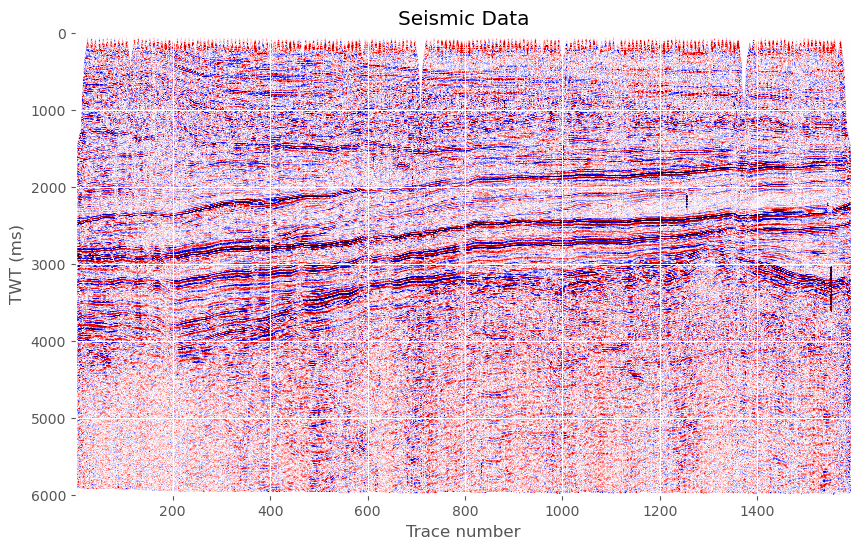

In [25]:
plot_segy(filename)

In [26]:
destination = 'datos_sismicos/cortado.sgy'
cut_time = 4000
cut_sample = int(cut_time / sample_rate)+1

In [27]:
with segyio.open(filename, ignore_geometry=True) as src:
    spec = segyio.tools.metadata(src)
    spec.samples = spec.samples[:cut_sample]
    with segyio.create(destination, spec) as dst:
        dst.text[0] = src.text[0]
        dst.bin = src.bin
        dst.bin.update(hns=len(spec.samples))
        dst.header = src.header
        dst.trace = src.trace

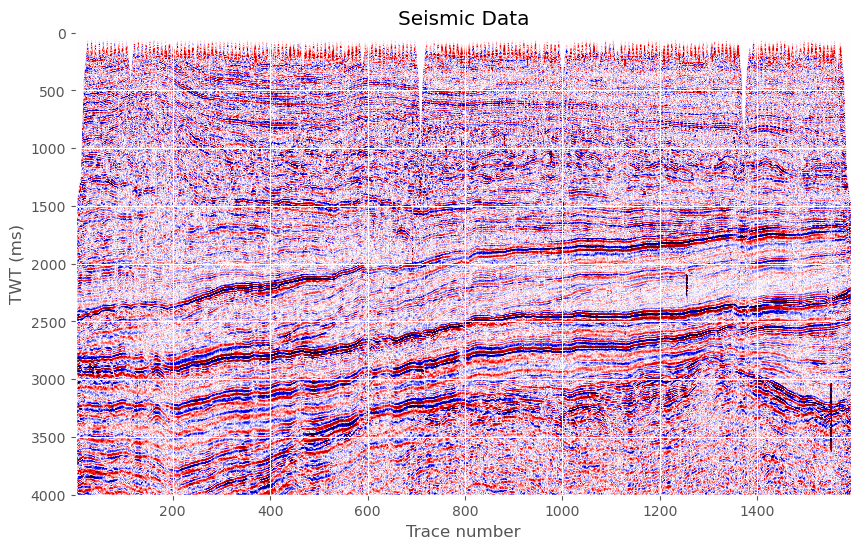

In [28]:
plot_segy(destination)

In [38]:
final = "datos_sismicos/resample_final.sgy"
new_sample_rate = 16
sampling_ratio = int(new_sample_rate/sample_rate)

with segyio.open(destination, ignore_geometry=True) as src:
    spec = segyio.tools.metadata(src)
    spec.samples = src.samples[:int(src.samples.size/2)]
    with segyio.create(final, spec) as dst:
        dst.text[0] = src.text[0]
        dst.bin = src.bin
        for ix, trace in enumerate(src.trace):
            dst.trace[ix] = scipy.signal.resample(trace, int(len(trace) / 2))
        dst.bin.update(hdt=new_sample_rate, hns=len(spec.samples))
        dst.header = src.header
        dst.trace = src.trace

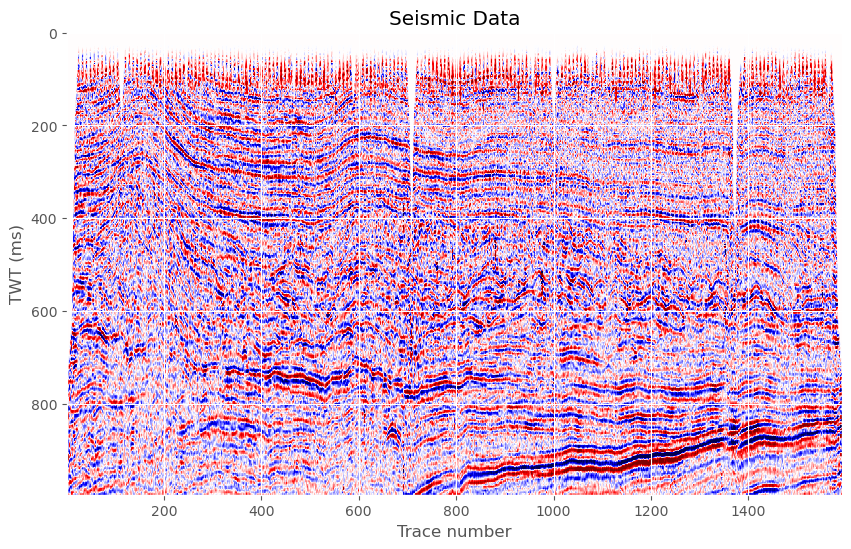

In [43]:
plot_segy(final)